<h2>Radical Counting Results</h2>

In [4]:
# Some imports to stop some annoying yellow underlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import importlib
import scipy

# Very important line to run the setup notebook!!!
%run do_plot_setup.ipynb
import cl2_utilities as cl2_utils

# Extract some shared values that are used to facilitate plotting. Call 'display' on any of them to see their contents.
plot_default_properties = get_and_apply_plot_defaults() #Ignore yellow underline
line_default_properties = get_default_line_properties() #Ignore yellow underline
cl2_experiment_constants = get_cl2_experiment_constants() #Ignore yellow underline
(all_conversion_data,all_bypass_data) = get_experimental_data() #Ignore underline. These two dataframes have all the experimental results.

In [5]:
# Whittle it down to the experiments we want and record the nominal Cl2 ppm readings
titration_data = all_conversion_data[all_conversion_data["experiment_name"].str.contains("Radical Count")]
titration_start_times = titration_data['start_time']
titration_data = titration_data.sort_values(['experiment_name','Cl2 LabJack: Cl2 reading minus zero (mV) baseline'])
titration_data['Cl2 Nominal Baseline (ppm)'] = (1,2,
                                        300,
                                        30, 60, 90,
                                        -1, 20,
                                        -1, 5, 10, 15,
                                        ) #Check these against experiment notes
titration_data = titration_data[titration_data['Cl2 Nominal Baseline (ppm)']!=-1]
#assert titration_data.shape[0]==8
titration_data = titration_data.sort_values(['Cl2 Nominal Baseline (ppm)'])
titration_bypass_data = all_bypass_data[all_bypass_data["experiment_name"].str.contains("Radical Count")]

# The Cl2 tank ppms are set manually here based on notes taken during each experiment; it's not recorded automatically in software.
cl2_tank_ppms = [20,20,20,20,100,100,100,1000,1000,1000]

# Extract the values and 95% CI from the Cl2 conversion data
(rad_count_cl2_baseline, rad_count_cl2_conversions, rad_count_cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(titration_data,titration_bypass_data,
                cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_percent_accuracy_95,
                override_cl2_baseline = titration_data['Cl2 Nominal Baseline (ppm)'])

# Convert to Numpy arrays
rad_count_cl2_baseline = np.array(rad_count_cl2_baseline)
rad_count_cl2_conversions = np.array(rad_count_cl2_conversions)
rad_count_cl2_conversion_95_ci = np.array(rad_count_cl2_conversion_95_ci)

# Separate out the 300 ppm point: it's only used in a single calculation and makes the graph look bad
rad_count_cl2_baseline = rad_count_cl2_baseline[:9]
cl2_conversion_300 = rad_count_cl2_conversions[9]
rad_count_cl2_conversions = rad_count_cl2_conversions[:9]
cl2_conversion_300_95_ci = rad_count_cl2_conversion_95_ci[9]
rad_count_cl2_conversion_95_ci = rad_count_cl2_conversion_95_ci[:9]

# Apply the linear regression
m_raw, b_raw, r_value, p_value, std_err = scipy.stats.linregress(rad_count_cl2_baseline,rad_count_cl2_conversions)
m = 2*m_raw # Want in units of Cl* available, which is 2x the Cl2 conversion in these experiments
b = 2*b_raw
#print("Linear regression R squared: ",r_value**2)

# Make the plot itself
use_error_bars = True
fig,ax = plt.subplots()
ax.plot()
ax.tick_params(width=plot_default_properties['box_linewidth'])
for spine in ax.spines.values():
    spine.set_linewidth(plot_default_properties['box_linewidth'])
x_vals = np.linspace(0,90,100)
ax.plot([0,85],[0,160],'k:',label='Cl$\\bullet$ production if all Cl$_2$$\\rightarrow$2Cl$\\bullet$')
ax.errorbar(rad_count_cl2_baseline,2*rad_count_cl2_conversions,2*rad_count_cl2_conversion_95_ci,capsize=3,
            color=line_default_properties['Cl2']['color'],marker='',linestyle='')
ax.plot(rad_count_cl2_baseline,2*rad_count_cl2_conversions,color=line_default_properties['Cl2']['color'],marker=line_default_properties['Cl2']['marker'],
        linestyle='',label='Measured total Cl$\\bullet$ production',ms=8) # Artificially blow up the markers for visibility

#for i in range(9):
#    print(rad_count_cl2_baseline[i],": ",np.round(rad_count_cl2_conversions[i],2)," ± ",np.round(rad_count_cl2_conversion_95_ci[i],2))

ax.plot(x_vals, m*x_vals+b,'--',color='xkcd:grey',label=('Trendline (R$^2$='+str(round(r_value**2,5))+')'))
ax.set_xlabel('Inlet Cl$_2$ (ppm)',fontweight=plot_default_properties['font_weight'])
ax.set_ylabel('Cl$\\bullet$ generated (ppm)',fontweight=plot_default_properties['font_weight'])

# Little helper function from stack overflow
def nearest_neighbor_interpolation(x, x_vals, y_vals):
    out = np.zeros(len(x))
    for i,x_i in enumerate(x):
        ab_vals = np.abs(x_vals-x_i)
        out[i] = y_vals[ab_vals.argmin()]
    return out

# Define the function that will give us radical budget as a function of inlet Cl2 concentration
def get_cl_radical_budget(query_cl2_concs): # Valid only for a 200 sccm flow rate
    query_cl2_concs = np.array(query_cl2_concs)
    # Interpolation method
    return (np.interp(query_cl2_concs, rad_count_cl2_baseline, 2*rad_count_cl2_conversions),
            np.interp(query_cl2_concs, rad_count_cl2_baseline, 2*rad_count_cl2_conversion_95_ci))
    # Linear regression method - deprecated
    #return ((m*query_cl2_concs+b),
    #        np.interp(query_cl2_concs, cl2_baseline, 2*cl2_conversion_95_ci))

def get_cl_radical_budget_300(): # This is separate for historical reasons but functions exactly the same as if the 300 ppm data point were in the interpolation
    return (2*cl2_conversion_300, 2*cl2_conversion_300_95_ci)

# Test plot the results; comment out when not in use.
#x_test = np.linspace(1,80,50)
#(y_test, e_test) = get_cl_radical_budget(x_test)
#ax.errorbar(x_test,y_test,e_test,capsize=3,color='m',marker='*',linestyle='')

# Store the plot for later; just say 'stored_radical_count_plot' to show it.
stored_radical_count_plot = fig
plt.savefig('exported_images/radical_count.png', bbox_inches='tight',dpi=300)
#ax.set_ylim(0,165)
#ax.set_xlim(0,95)

inset_ax = ax.inset_axes(
   [0.1, 0.65, 0.3, 0.3],  # [x, y, width, height] w.r.t. axes
    xlim=[0, 6], ylim=[0, 10], # sets viewport &amp; tells relation to main axes
    xticks=[0,1,2,3,4,5,6], yticks=[0,5,10],
)
inset_ax.plot([0,85],[0,160],'k:',label='Cl$^\\bullet$ production if all Cl$_2$$\\rightarrow$2Cl$^\\bullet$')
inset_ax.errorbar(rad_count_cl2_baseline,2*rad_count_cl2_conversions,2*rad_count_cl2_conversion_95_ci,capsize=3,
            color=line_default_properties['Cl2']['color'],marker='',linestyle='')
inset_ax.plot(rad_count_cl2_baseline,2*rad_count_cl2_conversions,color=line_default_properties['Cl2']['color'],marker=line_default_properties['Cl2']['marker'],
        linestyle='',label='Measured Cl$^\\bullet$ Production',ms=8) # Artificially blow up the markers for visibility

inset_ax.plot(x_vals, m*x_vals+b,'--',color='xkcd:grey',label=('Trendline (R$^2$='+str(round(r_value**2,5))+')'))
# add zoom leaders
ax.indicate_inset_zoom(inset_ax, edgecolor="blue")

ax.legend(loc='lower right')
pass

stored_radical_count_plot = fig
plt.savefig('exported_images/radical_count.png', bbox_inches='tight',dpi=300)

plt.close()

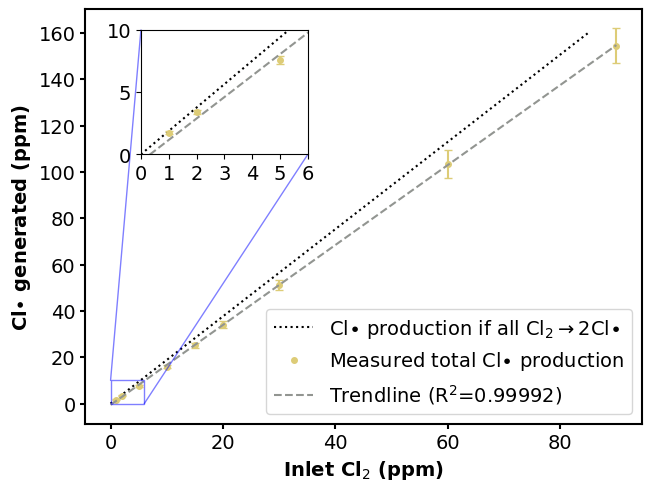

In [6]:
#print("Cl* budget at [Cl2]=300 ppm: ",round(2*cl2_conversion_300)," +- ",round(2*cl2_conversion_300_95_ci)," ppm.")
stored_radical_count_plot
